# About

This script compares the performance of the two oracles live on StarkNet for the ETH/USD feed.

Empiric emits events every time a source sends new data on-chain which lets anyone audit their public track record going back months. They have emitted over 3.5M events to date.

Stork contracts can be benchmarked by repeatedly polling their values. We ran a script that pulled data every 3 minutes (their update frequency) and stored it for analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
time_window = (1675209600, 1677490372)  # February

In [7]:
stork = pd.read_csv("stork_data.csv")
stork = stork.drop(columns="Unnamed: 0")
stork = stork.drop_duplicates().reset_index(drop=True)
stork["datetime"] = pd.to_datetime(stork["timestamp"], unit="s")
stork["value"] = stork["value"].apply(lambda x: float(x)/(10**18))
stork = stork[(stork["timestamp"] > time_window[0]) & (stork["timestamp"] <= time_window[1])].reset_index(drop=True)
stork.head()

,asset,value,timestamp,publisher,type,datetime
0,19514442401534788,1973.443049,1660361410,25789180169021501187677569358,1953063787,2022-08-13 03:30:10
1,19514442401534788,1976.379371,1660361950,25789180169021501187677569358,1953063787,2022-08-13 03:39:10
2,19514442401534788,1979.560802,1660362130,25789180169021501187677569358,1953063787,2022-08-13 03:42:10
3,19514442401534788,1982.577160,1660362670,25789180169021501187677569358,1953063787,2022-08-13 03:51:10
4,19514442401534788,1985.043269,1660363030,25789180169021501187677569358,1953063787,2022-08-13 03:57:10


In [8]:
len(stork)

277

In [16]:
empiric = pd.read_csv("../empiric-events.csv")
empiric = empiric.drop(columns=["Unnamed: 0", "pair_id", "volume", "price"])
empiric["datetime"] = pd.to_datetime(empiric["datetime"])
empiric = empiric[empiric["key"] == "ETH/USD"]
empiric.loc[:, ["transaction_hash",]] = empiric["transaction_hash"].apply(lambda x: hex(int(x)))
empiric = empiric[(empiric["timestamp"] > time_window[0]) & (empiric["timestamp"] <= time_window[1])].reset_index(drop=True)
empiric.head()

,source,publisher,timestamp,transaction_hash,key,value,datetime
0,BITSTAMP,EMPIRIC,1676482544,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1580.000,2023-02-15 17:35:44
1,CEX,EMPIRIC,1676482548,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1579.800,2023-02-15 17:35:48
2,COINBASE,EMPIRIC,1676482548,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1579.835,2023-02-15 17:35:48
3,BITSTAMP,EMPIRIC,1676482544,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1580.000,2023-02-15 17:35:44
4,CEX,EMPIRIC,1676482550,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1579.800,2023-02-15 17:35:50


In [38]:
len(empiric)

35381

In [19]:
chainlink = pd.read_csv("../chainlink.csv")
chainlink["datetime"] = pd.to_datetime(chainlink["timestamp"], unit="s")
chainlink = chainlink.drop(columns=["block_number", "round_id"])
chainlink = chainlink.rename(columns={"answer": "value"})
chainlink = chainlink[(chainlink["timestamp"] > time_window[0]) & (chainlink["timestamp"] <= time_window[1])].reset_index(drop=True)
chainlink.head()

,value,timestamp,datetime
0,1582.78023,1675230947,2023-02-01 05:55:47
1,1577.65145,1675234547,2023-02-01 06:55:47
2,1576.97342,1675238159,2023-02-01 07:55:59
3,1573.14324,1675238447,2023-02-01 08:00:47
4,1571.12130,1675241735,2023-02-01 08:55:35


In [20]:
len(chainlink)

1123

In [21]:
datasets = [(empiric, "Empiric"), (chainlink, "Chainlink")]

In [24]:
for dataset, label in datasets:
    dataset = dataset.sort_values("datetime")
    dataset["previous_datetime"] = dataset.shift(1)["datetime"]
    dataset["time_diff"] = dataset["datetime"] - dataset["previous_datetime"]
    dataset["seconds_diff"] = dataset["time_diff"].apply(lambda x: x.seconds)
    print(label)
    print(dataset["seconds_diff"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
    print("Outages")
    print(dataset[dataset["seconds_diff"] > 1200])

Empiric
count    35380.000000
mean        28.472951
std        106.997938
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
90%        114.000000
95%        181.000000
99%        296.000000
max       8216.000000
Name: seconds_diff, dtype: float64
Outages
         source    publisher   timestamp  \
157    BITSTAMP      EMPIRIC  1676494682   
161    BITSTAMP      EMPIRIC  1676497081   
165      GEMINI       GEMINI  1676498407   
172    BITSTAMP      EMPIRIC  1676500082   
1929     GEMINI       GEMINI  1676631304   
1930   BITSTAMP      EMPIRIC  1676634668   
1933     GEMINI       GEMINI  1676637006   
17405  BITSTAMP  EQUILIBRIUM  1676995925   
17432  BITSTAMP  EQUILIBRIUM  1677001501   
17434  COINBASE  EQUILIBRIUM  1677003903   
17443  COINBASE  EQUILIBRIUM  1677005702   
17451  BITSTAMP  EQUILIBRIUM  1677010801   
17465    GEMINI       GEMINI  1677013207   
21717       CEX  EQUILIBRIUM  1677126603   
22474  BITSTAMP  EQUILIBRIUM  1677150119   
224

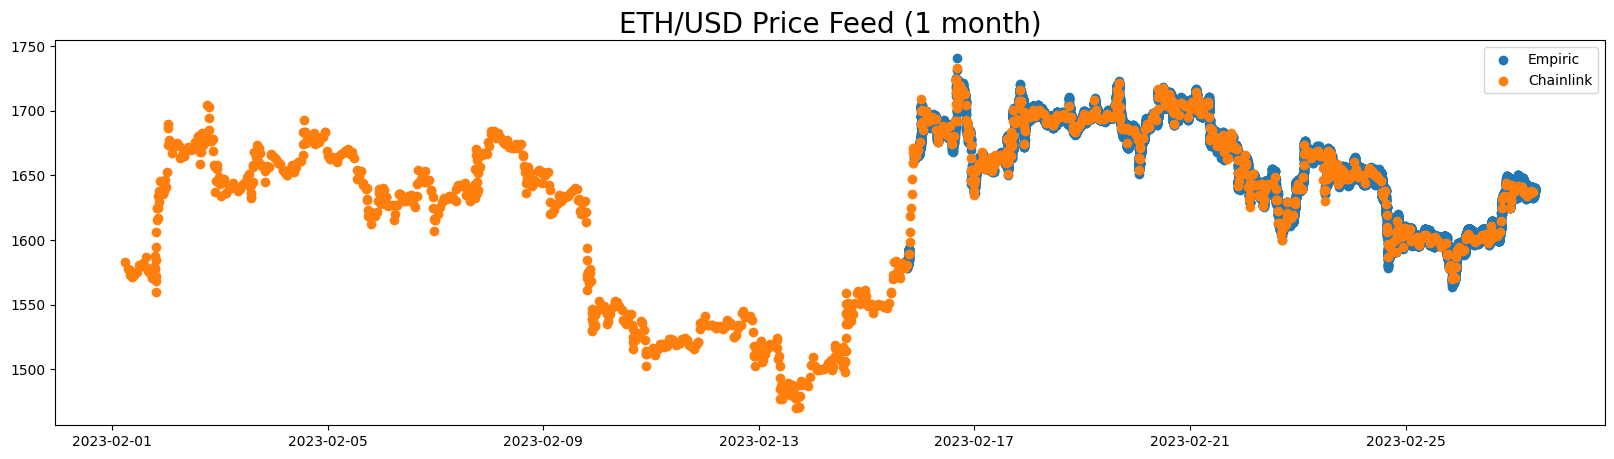

In [29]:
plt.figure(figsize=(20, 5))
for dataset, label in datasets:
    plt.scatter(dataset["datetime"], dataset["value"], label=label)

plt.title("ETH/USD Price Feed (1 month)", fontsize=20)
plt.legend()
plt.show()

## Precision

In [30]:
# Need to aggregate - take the median of all the values currently available

from statistics import median

publisher_values = {}
empiric["current_median"] = 0
for i, row in empiric.iterrows():
    publisher_values[row["source"]] = row["value"]
    empiric.loc[i, "current_median"] = median(publisher_values.values())

In [31]:
# Then find the Chainlink datapoint for benchmarking precision
chainlink = chainlink.sort_values("timestamp").reset_index(drop=True)
empiric["last_chainlink_timestamp"] = 0
last_chainlink_timestamp_index = 0
last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]
for i, row in empiric.iterrows():
    if last_chainlink_timestamp > time_window[1] or last_chainlink_timestamp_index+1 >= len(chainlink):
        break # Reached end of time window
    if row["timestamp"] > chainlink.loc[last_chainlink_timestamp_index+1, "timestamp"]: # Move on to next timestamp
        last_chainlink_timestamp_index += 1
        last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]

    empiric.loc[i, "last_chainlink_timestamp"] = last_chainlink_timestamp

In [32]:
combined_empiric = pd.merge(chainlink, empiric, left_on='timestamp', right_on="last_chainlink_timestamp", how='inner', suffixes=["_chainlink", "_empiric"])
combined_empiric["difference"] = combined_empiric["current_median"] - combined_empiric["value_chainlink"]
combined_empiric["percentage_difference"] = combined_empiric["difference"] / combined_empiric["value_chainlink"]
combined_empiric = combined_empiric[combined_empiric["timestamp_chainlink"] < combined_empiric["timestamp_empiric"]]
combined_empiric

,value_chainlink,timestamp_chainlink,datetime_chainlink,source,publisher,timestamp_empiric,transaction_hash,key,value_empiric,datetime_empiric,current_median,last_chainlink_timestamp,difference,percentage_difference
0,1577.65145,1675234547,2023-02-01 06:55:47,BITSTAMP,EMPIRIC,1676482544,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1580.000000,2023-02-15 17:35:44,1580.0000,1675234547,2.348550,0.001489
1,1576.97342,1675238159,2023-02-01 07:55:59,CEX,EMPIRIC,1676482548,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1579.800000,2023-02-15 17:35:48,1579.9000,1675238159,2.926580,0.001856
2,1573.14324,1675238447,2023-02-01 08:00:47,COINBASE,EMPIRIC,1676482548,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1579.835000,2023-02-15 17:35:48,1579.8350,1675238447,6.691760,0.004254
3,1571.12130,1675241735,2023-02-01 08:55:35,BITSTAMP,EMPIRIC,1676482544,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1580.000000,2023-02-15 17:35:44,1579.8350,1675241735,8.713700,0.005546
4,1572.75617,1675245323,2023-02-01 09:55:23,CEX,EMPIRIC,1676482550,0x155533e8fdd7ed44969bb7dbcc63eeb11cd4004653b5...,ETH/USD,1579.800000,2023-02-15 17:35:50,1579.8350,1675245323,7.078829,0.004501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35322,1636.62595,1677484823,2023-02-27 08:00:23,KAIKO,EMPIRIC,1677487920,0x4eeb776c5ad75c64347ae09b3cc2a2c4b9f4353b0c4a...,ETH/USD,1635.375643,2023-02-27 08:52:00,1636.3575,1677484823,-0.268450,-0.000164
35323,1636.62595,1677484823,2023-02-27 08:00:23,BITSTAMP,EMPIRIC,1677487974,0x4eeb776c5ad75c64347ae09b3cc2a2c4b9f4353b0c4a...,ETH/USD,1635.200000,2023-02-27 08:52:54,1636.3575,1677484823,-0.268450,-0.000164
35324,1636.62595,1677484823,2023-02-27 08:00:23,CEX,EMPIRIC,1677487976,0x4eeb776c5ad75c64347ae09b3cc2a2c4b9f4353b0c4a...,ETH/USD,1640.310000,2023-02-27 08:52:56,1636.3575,1677484823,-0.268450,-0.000164
35325,1636.62595,1677484823,2023-02-27 08:00:23,GEMINI,GEMINI,1677488104,0x12a3ae8abed157bc3d510052fabf53bfec71c644a973...,ETH/USD,1637.040000,2023-02-27 08:55:04,1636.9125,1677484823,0.286550,0.000175


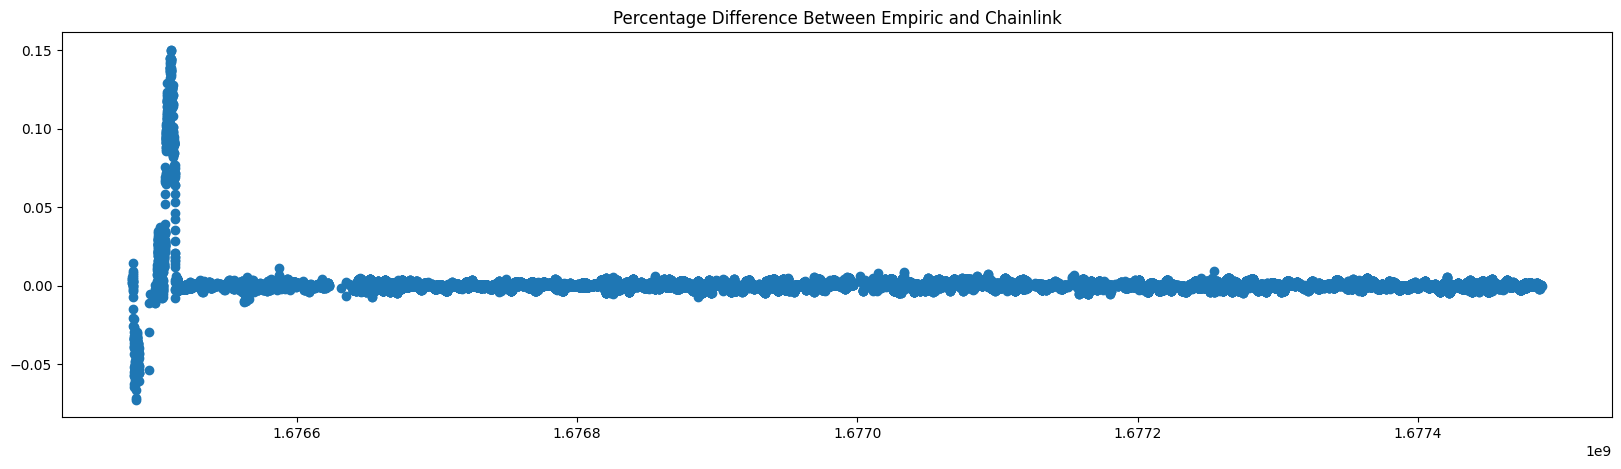

In [33]:
plt.figure(figsize=(20, 5))
plt.scatter(combined_empiric["timestamp_empiric"], combined_empiric["percentage_difference"])
plt.title("Percentage Difference Between Empiric and Chainlink")
plt.show()

In [34]:
max(combined_empiric["percentage_difference"])

0.15029589823821513

In [35]:
# Then find the Chainlink datapoint for benchmarking precision
chainlink = chainlink.sort_values("timestamp").reset_index(drop=True)
stork["last_chainlink_timestamp"] = 0
last_chainlink_timestamp_index = 0
last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]
for i, row in stork.iterrows():
    if last_chainlink_timestamp > time_window[1] or last_chainlink_timestamp_index+1 >= len(chainlink):
        break # Reached end of time window
    if row["timestamp"] > chainlink.loc[last_chainlink_timestamp_index+1, "timestamp"]: # Move on to next timestamp
        last_chainlink_timestamp_index += 1
        last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]

    stork.loc[i, "last_chainlink_timestamp"] = last_chainlink_timestamp

NameError: name 'stork' is not defined

In [221]:
combined_stork = pd.merge(chainlink, stork, left_on='timestamp', right_on="last_chainlink_timestamp", how='inner', suffixes=["_chainlink", "_stork"])
combined_stork["difference"] = combined_stork["value_stork"] - combined_stork["value_chainlink"]
combined_stork["percentage_difference"] = combined_stork["difference"] / combined_stork["value_chainlink"]
combined_stork = combined_stork[combined_stork["timestamp_chainlink"] < combined_stork["timestamp_stork"]]
combined_stork

,value_chainlink,timestamp_chainlink,datetime_chainlink,asset,value_stork,timestamp_stork,publisher,type,datetime_stork,last_chainlink_timestamp,difference,percentage_difference
3,1988.290000,1660362370,2022-08-13 03:46:10,1.951444e+16,1982.577160,1.660363e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 03:51:10,1660362370,-5.712840,-0.002873
4,1988.290000,1660362370,2022-08-13 03:46:10,1.951444e+16,1985.043269,1.660363e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 03:57:10,1660362370,-3.246731,-0.001633
5,1991.778051,1660363136,2022-08-13 03:58:56,1.951444e+16,1992.241509,1.660364e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:09:10,1660363136,0.463458,0.000233
6,1991.778051,1660363136,2022-08-13 03:58:56,1.951444e+16,1991.161022,1.660364e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:12:10,1660363136,-0.617028,-0.000310
7,2003.353785,1660364702,2022-08-13 04:25:02,1.951444e+16,1996.648492,1.660365e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:33:10,1660364702,-6.705293,-0.003347
...,...,...,...,...,...,...,...,...,...,...,...,...
272,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1981.590398,1.660486e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:06:10,1660485315,2.010398,0.001016
273,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1982.350588,1.660487e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:15:09,1660485315,2.770588,0.001400
274,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1984.556139,1.660487e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:24:10,1660485315,4.976139,0.002514
275,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1981.470368,1.660489e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:54:09,1660485315,1.890368,0.000955


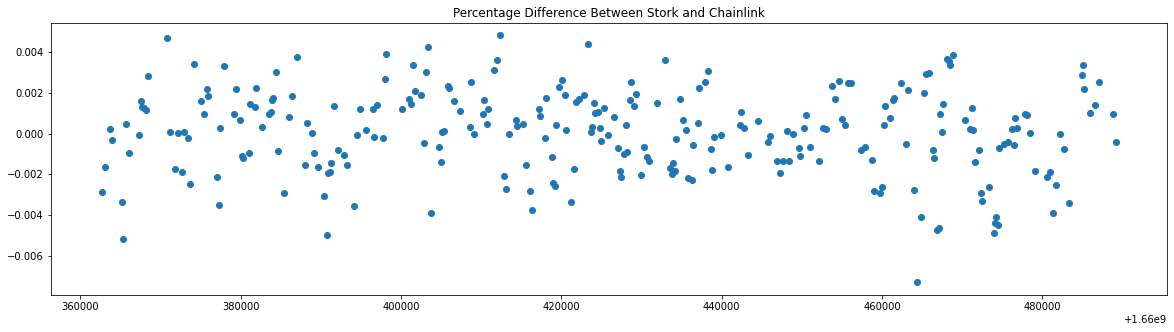

In [222]:
plt.figure(figsize=(20, 5))
plt.scatter(combined_stork["timestamp_stork"], combined_stork["percentage_difference"])
plt.title("Percentage Difference Between Stork and Chainlink")
plt.show()

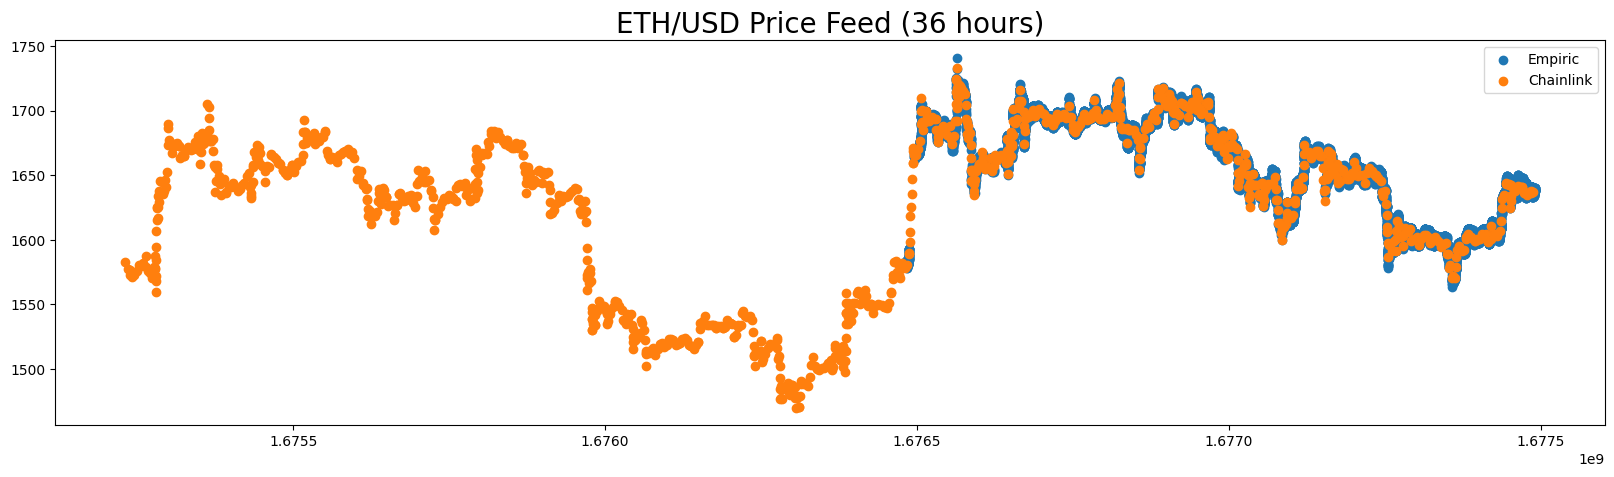

In [36]:
plt.figure(figsize=(20, 5))
for dataset, label in datasets:
    plt.scatter(dataset["timestamp"], dataset["value"], label=label)

plt.title("ETH/USD Price Feed (36 hours)", fontsize=20)
plt.legend()
plt.show()

In [223]:
max(combined_stork["percentage_difference"])

0.004830634689614337